# refellips demo: Solid/Aid
This demo presents an example use case for fitting multi-wavelength multi-angle ellipsometry data with refellips. This example also demonstrates the use of the provided plotting tools.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

In [3]:
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import RI

In [4]:
#Include plotting tools
sys.path.insert(1,'../tools')
from plottools import plot_ellipsdata, plot_structure

### Import data

In [5]:
dname = 'WVASE_example_2nmSiO2_20nmPNIPAM_MultiWavelength.txt'
data = DataSE(data=dname)
np.unique(data.wav)

array([600., 700.])

### Build model

In [6]:
si     = RI('../refellips/materials/silicon.csv')
sio2   = RI('../refellips/materials/silica.csv')
PNIPAM = RI('../refellips/materials/pnipam.csv')
air    = RI('../refellips/materials/air.csv')

PNIPAM_layer = PNIPAM(150)
PNIPAM_layer.thick.setp(vary=True, bounds=(100,500))

struc = air() | PNIPAM_layer | sio2(20) | si()

model = ReflectModelSE(struc, wavelength=658)

# Fitting experimental data

### Model & data pre fit

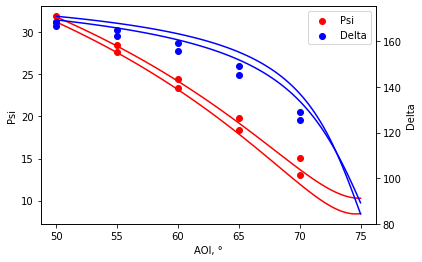

In [7]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50,75,100)

for dat in data:
    model.wav = dat._current_wav
    psi, delta = model(aois)
    ax.plot(aois, psi, color='r')
    p = ax.scatter(dat.aoi, dat.psi, color='r')

    axt.plot(aois, delta, color='b')
    d = axt.scatter(dat.aoi, dat.delta, color='b')

    ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
    ax.set(ylabel='Psi', xlabel='AOI, °')
    axt.set(ylabel='Delta')

In [8]:
objective = ObjectiveSE(model, data)

In [9]:
objective.residuals()

array([ 0.07489973,  0.14926004,  0.29673199,  0.60701437,  1.30096573,
       -2.65638767, -3.51837138, -4.72878815, -6.46076346, -8.42972259,
        0.04674781,  0.10248017,  0.21820546,  0.47122099,  1.09163042,
       -2.33378554, -3.1199899 , -4.24923616, -5.98783724, -8.30932223])

In [10]:
fitter = CurveFitter(objective)
fitter.fit(method='least_squares');

### Model & data post fit

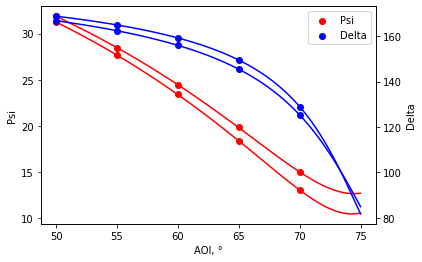

In [11]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50,75,100)

for dat in data:
    model.wav = dat._current_wav
    psi, delta = model(aois)
    ax.plot(aois, psi, color='r')
    p = ax.scatter(dat.aoi, dat.psi, color='r')

    axt.plot(aois, delta, color='b')
    d = axt.scatter(dat.aoi, dat.delta, color='b')

    ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
    ax.set(ylabel='Psi', xlabel='AOI, °')
    axt.set(ylabel='Delta')

In [12]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter: 'wavelength'  , value=700 (fixed)  , bounds=[-inf, inf]>
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'air'     
<Parameter: 'air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'air - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:    'pnipam'    
<Parameter:'pnipam - thick', value=194.232 +/- 0.143, bounds=[100.0, 500.0]>
<Parameter:'pnipam - rough', value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'pnipam - volfrac solvent', value=0 (fixed)  , bounds=[0

## Using the plotting tools

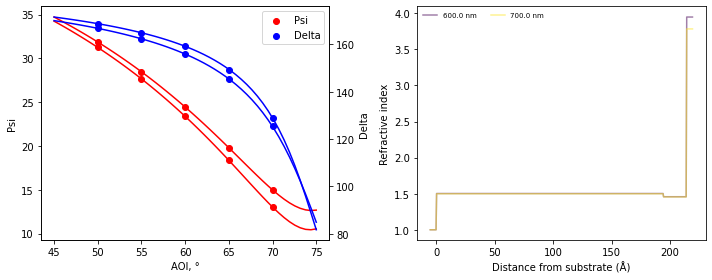

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

plot_ellipsdata(ax[0], data=data, model=model, xaxis='aoi')
plot_structure(ax[1], objective=objective)

fig.tight_layout()